# Vehicle trajectory tracking

In the following two tasks, you will design tracking controller to track the desired path for kinematic bicycle models.

In task 1, you will design a time-varying LQR to track the path alone the reference trajectory. 

In task 2, you will design a linear MPC to track the path while enforcing the bounds on inputs. 

## 1. System models
The state of the vehicle is defined as the position $\left[x, y\right]$, yaw angle $\psi$, and the velocity $v$. The vehicle is controlled by the steering angle of front wheel $\delta$ and the acceleration $a$.

Thus, the dynamics of the vehicle can be expressed as:

$$
\frac{d}{dt} \begin{bmatrix} x \\ y \\ \psi \\ v \end{bmatrix}
= \begin{bmatrix} v\cos(\psi + \beta) \\
                  v\sin(\psi + \beta) \\
                  \frac{v}{L_r} \sin\beta \\
                  a
  \end{bmatrix}, \text{with } \beta := \arctan(\frac{L_r}{L_r + L_f} \arctan \delta).
$$

where $L_r$ and $L_f$ is distance from the rear or front axes to the center of the vehicle. Let the state be $s:= [x, y, \psi, v]$.

We apply the explicit Euler integration to obtain the discrete-time dynamics model of $\dot{s}=f(s, u) \ \ \text{as}\ \ s_{k+1} = s_{k} + f(s_k, u_k) \Delta t.$

For more details about this model: https://link.springer.com/book/10.1007/978-1-4614-1433-9

## 2. Linearization around reference trajectory

Given the reference trajectory $\left(\bar{s}_{k}, \bar{u}_{k}\right)_{k=0,2,\cdots, N-1}$, we have the linearized system as:

$ (s_{k+1} - \bar{s}_{k+1}) = \frac{df(s_k, u_k)}{ds_k}|_{\bar{s}_k}(s_{k} - \bar{s}_k) + \frac{df(s_k, u_k)}{du_k}|_{\bar{u}_k}(u_{k} - \bar{u}_k) + h.o.t(s_k, u_k)$, where $h.o.t()$ denotes the terms with order higher than 1. 

Then we have the perturbed state dynamics as:

$ \delta s_{k+1} = A_k\delta s_{k} + B_k\delta u_{k} $, with $A_k:= \frac{df(s_k, u_k)}{ds_k}|_{\bar{s}_k}$ and $B_k := \frac{df(s_k, u_k)}{du_k}|_{\bar{u}_k}$.

We have 

$$A_k(s_k) = \begin{bmatrix} 1 & 0 & -\Delta tv\sin(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r))) &  \Delta t\cos(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r))) \\
                             0 & 1 &  \Delta tv\cos(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r)))&                              \Delta t\sin(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r))) \\
                             0 & 0 &                                                   1& (\Delta t\arctan(\delta))/(((L_r^2\arctan(\delta)^2)/(L_f + L_r)^2 + 1)^{(1/2)}(L_f + L_r)) \\
                             0 & 0 &                                                   0&                                                                             1 \\ \end{bmatrix}
$$

$$
B_k(s_k)   = \begin{bmatrix} 0& -(\Delta tL_rv\sin(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r))))/((\delta^2 + 1)((L_r^2\arctan(\delta)^2)/(L_f + L_r)^2 + 1)(L_f + L_r)) \\
                             0&  (\Delta tL_rv\cos(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r))))/((\delta^2 + 1)((L_r^2\arctan(\delta)^2)/(L_f + L_r)^2 + 1)(L_f + L_r)) \\
                             0&                                               (\Delta t v)/((\delta^2 + 1)((L_r^2\arctan(\delta)^2)/(L_f + L_r)^2 + 1)^{3/2}(L_f + L_r)) \\
                             \Delta t&                                                                                                                               0 \\ \end{bmatrix}
$$

## 3. Tasks

### 3.1 Task 1
Implement the LQR algorithm using cvx. 
$
\begin{equation}
    \begin{aligned}
    \min_{\delta s_k, \delta u_k} & \ \delta s_N^TP\delta s_N + \sum_{k=0}^{N-1} \delta s_k^TQ\delta s_k + \delta u_k^TR\delta u_k \\ 
    \text{s.t. } &\delta s_{k+1} = A_k\delta s_{k} + B_k\delta u_k, \ k = 0, \dots, N-1, \\
                 &\delta s_0 = \delta s_{init}.
    \end{aligned}
\end{equation}
$

### 3.2 Task 2

Implement the convex MPC using cvx. 

$
\begin{equation}
    \begin{aligned}
    \min_{\delta s_k, \delta u_k} & \ \delta s_N^TP\delta s_N + \sum_{k=0}^{N-1} \delta s_k^TQ\delta s_k + \delta u_k^TR\delta u_k \\ 
    \text{s.t. } &\delta s_{k+1} = A_k\delta s_{k} + B_k\delta u_k, \ k = 0, \dots, N-1, \\
                 & u_{\min} - \bar{u}_k \le \delta u_k \le u_{\max} - \bar{u}_k, \\
                 &\delta s_0 = \delta s_{init}.
    \end{aligned}
\end{equation}
$

## 4. Submission

Please fill **LQR_Controller()** for task-1 and  **CMPC_Controller()** for task-2.

The reference trajectory and preview horizon $N$ are provided. You will need to tune the the weight $P, Q, R$. 

You can use **calc_Jacobian()** to compute the Jacobian matrices in the controller loop. This function is optional and won't be tested in autograder.

### 4.1 Requirement

1. Track the referece trajectory as close as possible.

2. The input constraints are satisfied for MPC case. 

### 4.2 Remark
1. We will test your controller with varying $x0$. You can use the range specified in the comments as a reference to test your controller.

In [466]:
%load_ext autoreload
%autoreload 2
from cmpc_utils import *
from cmpc_controller import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [467]:
param = {
    "h":0.05,
    "T":15.,
    "L_f": 1.,
    "L_r":1.,
    "a_lim": [-10.0, 4.],
    "delta_lim": [-0.8, 0.8]
}
Sim = BicycleSim(param)
u_bar, x_bar = Sim.GenRef(5, 5)

# Task 1

In [ ]:
preview = 20
x0 = np.array([2, 2, 3.14 * 0.3, 2]) # [x, y, theta, v], x 0-5, y 0-5, theta 0-0.6*pi, v 0-5
controller = lambda x, u, xint: LQR_Controller(x, u, xint, param)
x_log, u_log = Sim.SimVehicle(x_bar, u_bar, preview, x0, controller)

x_err = x_log - x_bar
x_err = np.linalg.norm(x_err[-100:], 'fro')
print('Error:', x_err)

plt.figure(figsize=(5, 5))
plt.plot(x_bar[0, 0], x_bar[0, 1], 'ko-')
plt.plot(x_log[0, 0], x_log[0, 1], 'ro-')
plt.plot(x_bar[:, 0], x_bar[:, 1], 'k-', label = "reference")
plt.plot(x_log[:, 0], x_log[:, 1], 'r--', label = "vehicle")
plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('trajectory')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(u_bar[:, 0], 'k-', label = "reference")
plt.plot(u_log[:, 0], 'r--', label = "vehicle")
plt.title('Acceleration')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(20, 3))
plt.plot(u_bar[:, 1], 'k-', label = "reference")
plt.plot(u_log[:, 1], 'r--', label = "vehicle")
plt.title('Steering Angle')
plt.legend()
plt.grid()
plt.show()

# Task 2

Error: 0.00018429260276427793


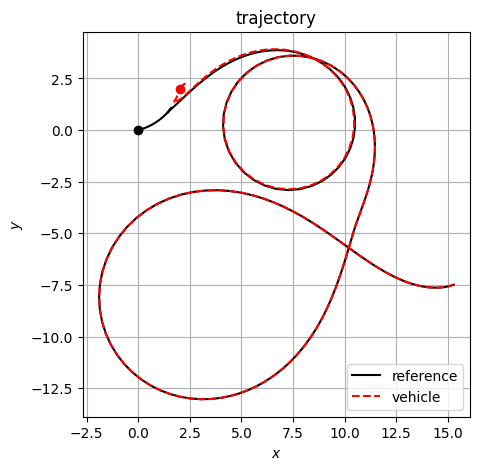

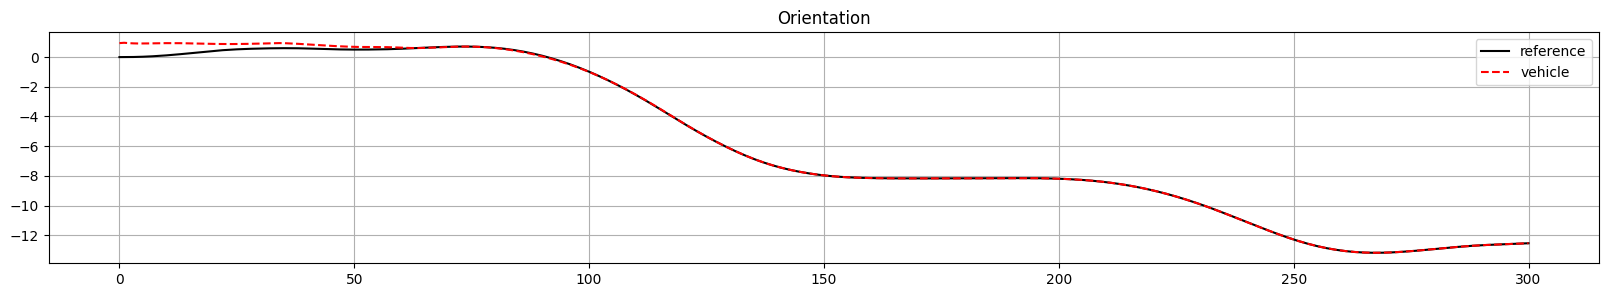

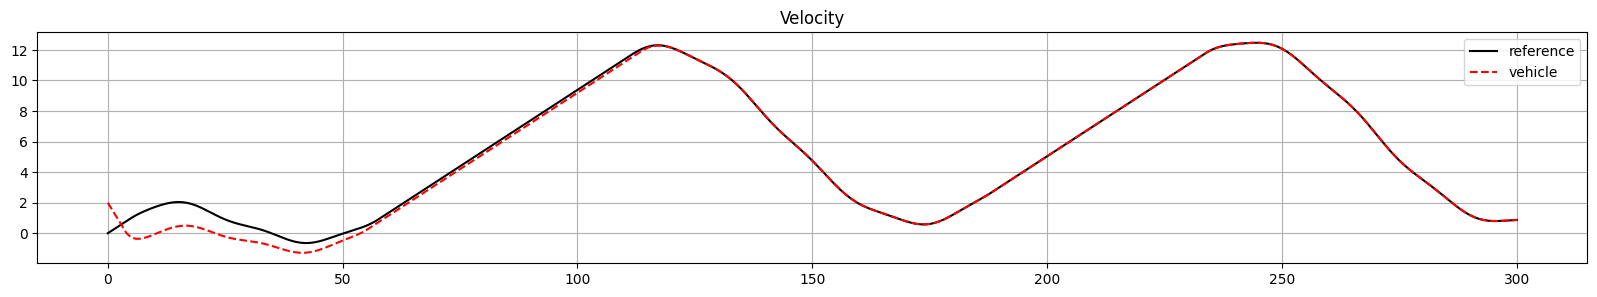

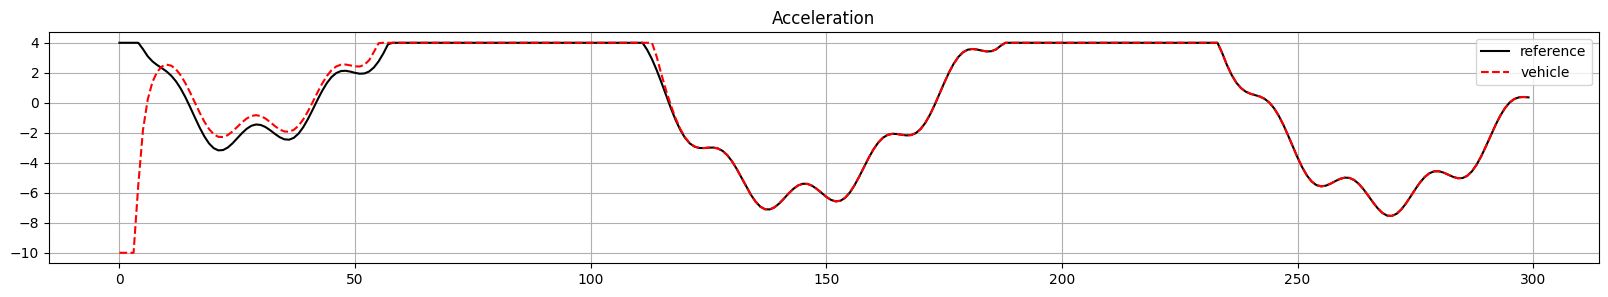

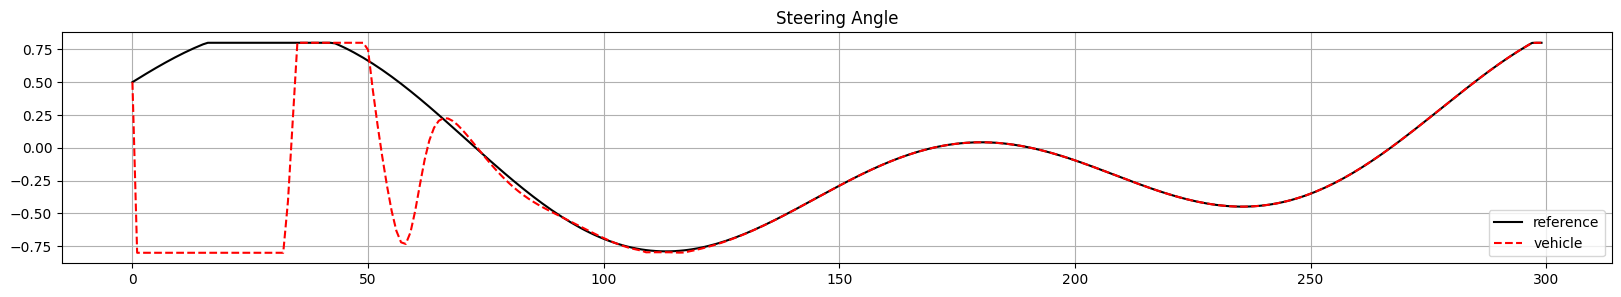

In [ ]:
preview = 20
x0 = np.array([2, 2, 3.14 * 0.3, 2]) # [x, y, theta, v], x 0-5, y 0-5, theta 0-0.6*pi, v 0-5
controller = lambda x, u, xint: CMPC_Controller(x, u, xint, param)
x_log, u_log = Sim.SimVehicle(x_bar, u_bar, preview, x0, controller)

x_err = x_log - x_bar
x_err = np.linalg.norm(x_err[-100:], 'fro')
print('Error:', x_err)

plt.figure(figsize=(5, 5))
plt.plot(x_bar[0, 0], x_bar[0, 1], 'ko-')
plt.plot(x_log[0, 0], x_log[0, 1], 'ro-')

plt.plot(x_bar[:, 0], x_bar[:, 1], 'k-', label = "reference")
plt.plot(x_log[:, 0], x_log[:, 1], 'r--', label = "vehicle")
plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('trajectory')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(x_bar[:, 2], 'k-', label = "reference")
plt.plot(x_log[:, 2], 'r--', label = "vehicle")
plt.title('Orientation')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(20, 3))
plt.plot(x_bar[:, 3], 'k-', label = "reference")
plt.plot(x_log[:, 3], 'r--', label = "vehicle")
plt.title('Velocity')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(20, 3))
plt.plot(u_bar[:, 0], 'k-', label = "reference")
plt.plot(u_log[:, 0], 'r--', label = "vehicle")
plt.title('Acceleration')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(20, 3))
plt.plot(u_bar[:, 1], 'k-', label = "reference")
plt.plot(u_log[:, 1], 'r--', label = "vehicle")
plt.title('Steering Angle')
plt.legend()
plt.grid()
plt.show()

### Error ###
#0.01946992969544627
#0.002796302292144018
#0.00044883701024707353
#0.00018429260276427793